In [ ]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.8.0
Num GPUs Available:  1


## Loading Data

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/255
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/255
y_train_1h = pd.get_dummies(pd.DataFrame(y_train)[0]).to_numpy()
print(x_train.shape, y_train.shape, y_train_1h.shape, x_test.shape, y_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 784) (60000,) (60000, 10) (10000, 784) (10000,)


In [ ]:
m, n = x_train.shape
c = y_train_1h.shape[1]
p = 15
print(m, n, p, c)

60000 784 15 10


## Implementing Model in Tensorflow

In [ ]:
def crossEntropySoftmax(softmaxScore, y1h):
    a = tf.multiply(softmaxScore, y1h)
    b = tf.reduce_sum(a,axis=1, keepdims=True)
    c = -tf.math.log(b)
    return c

def adamOptimizer(dxs, first_moments, second_moments, t):
    dxc = []
    fm = []
    sm = []
    for dx, first_moment, second_moment in zip(dxs, first_moments, second_moments):
        first_moment = 0.9 * first_moment + (1-0.9) * dx
        second_moment = 0.999 * second_moment + (1-0.999) * dx * dx
        first_unbias = first_moment / (1 - 0.9 ** t)
        second_unbias = second_moment/ (1 - 0.999 ** t)
        dxc.append(first_unbias / (tf.sqrt(second_unbias) + 1e-7))
        fm.append(first_moment)
        sm.append(second_moment)
    return dxc, fm, sm

def batchNorm(x):
    mean = tf.reduce_mean(x, axis=0)
    var = tf.math.reduce_variance(x, axis=0)
    return (x - mean) / tf.math.sqrt(var+1e-7)

In [ ]:
x = tf.constant (x_train, dtype=tf.float32)
y = tf.constant(y_train_1h, dtype=tf.float32)

In [ ]:
metric = tf.metrics.Accuracy()
initializer = tf.initializers.GlorotUniform()
w1 = tf.Variable(initializer(shape=(n,p)), dtype=tf.float32)
b1 = tf.Variable(initializer(shape=(1,p)), dtype=tf.float32)
w2 = tf.Variable(initializer(shape=(p,c)), dtype=tf.float32)
b2 = tf.Variable(initializer(shape=(1,c)), dtype=tf.float32)

gm1 = tf.Variable(tf.ones(shape=(p,)), dtype=tf.float32)
bt1 = tf.Variable(tf.zeros(shape=(p,)), dtype=tf.float32)
gm2 = tf.Variable(tf.ones(shape=(c,)), dtype=tf.float32)
bt2 = tf.Variable(tf.zeros(shape=(c,)), dtype=tf.float32)

In [ ]:
lr = 0.01
itr = 2000
start_time = time.time()
prm = np.empty((1,3))

fm = [0,0,0,0,0,0,0,0]
sm = [0,0,0,0,0,0,0,0]

for i in range(itr+1):
    with tf.GradientTape() as g:
        g.watch([w1, b1, gm1, bt1, w2, b2, gm2, bt2])
        # Forward Pass
        z1 = tf.matmul(x, w1) + b1
        z1_norm = batchNorm(z1)
        z1_out = z1_norm * gm1 + bt1
        a1 = tf.nn.relu(z1_out)
        
        z2 = tf.matmul(a1, w2) + b2
        z2_norm = batchNorm(z2)
        z2_out = z2_norm * gm2 + bt2
        a2 = tf.nn.softmax(z2_out)
        
        ce = crossEntropySoftmax(a2, y)
        loss = tf.reduce_mean(ce)
        dw1, db1, dgm1, dbt1, dw2, db2, dgm2, dbt2 = g.gradient(loss, [w1, b1, gm1, bt1, w2, b2, gm2, bt2])
        
        #Adam Optimizer
        
        (dw1, db1, dgm1, dbt1, dw2, db2, dgm2, dbt2) , fm, sm = adamOptimizer([dw1, db1, dgm1, dbt1, dw2, db2, dgm2, dbt2], fm, sm, i+1)
        
        #Gradient Update
        w1.assign_sub(lr*dw1)
        b1.assign_sub(lr*db1)
        gm1.assign_sub(lr*dgm1)
        bt1.assign_sub(lr*dbt1)
        w2.assign_sub(lr*dw2)
        b2.assign_sub(lr*db2)
        gm2.assign_sub(lr*dgm2)
        bt2.assign_sub(lr*dbt2)
        
        #Accuracy
        metric.update_state(tf.argmax(y, 1), tf.argmax(a2,1))
        acc = metric.result().numpy()
        prm = np.append(prm, [[i,loss.numpy(), acc]], axis=0)
        
        #Printing Parameters
        if i%(itr/10) ==0:
            print(i, " Loss:",loss.numpy(), " Accuracy:",acc)
end_time = time.time()
print("Complete!!!", " Loss:",loss.numpy(), " Accuracy:",acc)
print("Time Elapsed:" , (end_time - start_time)/60, "Minutes")

0  Loss: 0.07196133  Accuracy: 0.96274245
200  Loss: 0.056649152  Accuracy: 0.96496826
400  Loss: 0.044548184  Accuracy: 0.96833414
600  Loss: 0.036483042  Accuracy: 0.97118217
800  Loss: 0.033046465  Accuracy: 0.97355354
1000  Loss: 0.033934608  Accuracy: 0.97559184
1200  Loss: 0.023317644  Accuracy: 0.977334
1400  Loss: 0.02053908  Accuracy: 0.9788714
1600  Loss: 0.018290035  Accuracy: 0.9802043
1800  Loss: 0.016372222  Accuracy: 0.9813669
2000  Loss: 0.015365214  Accuracy: 0.9822935
Complete!!!  Loss: 0.015365214  Accuracy: 0.9822935
Time Elapsed: 1.479423983891805 Minutes


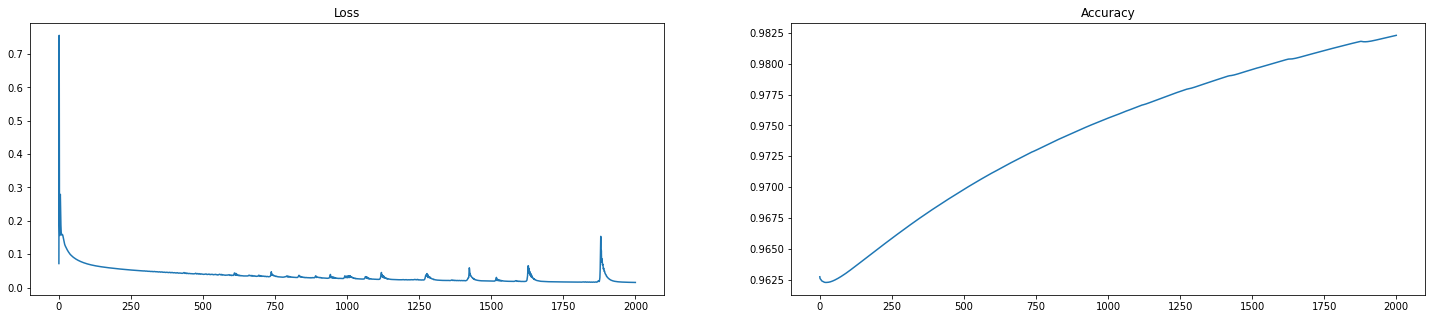

In [ ]:
plt.figure(figsize=(25, 5))
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(prm[1:,0], prm[1:,1])
plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(prm[1:,0], prm[1:,2])
plt.show()

## Test Accuracy

In [ ]:
def testAcuracy(x, y):
    z1 = tf.matmul(x, w1) + b1
    z1_norm = batchNorm(z1)
    z1_out = z1_norm * gm1 + bt1
    a1 = tf.nn.relu(z1_out)

    z2 = tf.matmul(a1, w2) + b2
    z2_norm = batchNorm(z2)
    z2_out = z2_norm * gm2 + bt2
    a2 = tf.nn.softmax(z2_out)
    
    metric.update_state(tf.argmax(y, 1), tf.argmax(a2,1))
    acc = metric.result().numpy()
    return acc
"Test Accuracy:", testAcuracy(tf.constant(x_test, tf.float32), pd.get_dummies(pd.DataFrame(y_test)[0]).to_numpy()) * 100

('Test Accuracy:', 98.22903871536255)